<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# autoreload updated and newly installed packages
# without having to restart Jupyter kernel
%load_ext autoreload
%autoreload 2
# Some little interaction with matplotlib,
# although this botebook tries to only use plotly.
%matplotlib inline                
# Avoid using Jedi for faster autocomplete (tab)
%config Completer.use_jedi = False

## Crack growth analysis

### Hollow cylinder with crack on the external surface 

In [2]:
# Standard imports
import datetime
import platform
import os
import sys
from typing import List
# Non-standard imports
import matplotlib
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import plotly.graph_objs as go
# py-fatigue import
import py_fatigue as pf
# Paths of this tutorial and of the data
TUTORIAL_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(TUTORIAL_PATH, "Data")
if not TUTORIAL_PATH in sys.path:
    sys.path.append(TUTORIAL_PATH)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
print(f"Platform: {platform.platform()}")
print(f"Python version: {sys.version}")
print(f"py-fatigue version: {pf.styling.TermColors.CBOLD}{pf.__version__}")

print(f"{pf.styling.TermColors.CWHITEBG}\
{pf.styling.TermColors.CBOLD}\
{pf.styling.TermColors.CBLUE}")
      
print(f"DATA_PATH = {DATA_PATH}")
print(f"TUTORIAL_PATH = {TUTORIAL_PATH}")

print(f"{pf.styling.TermColors.CEND}")

Platform: Linux-6.5.0-1025-oem-x86_64-with-glibc2.35
Python version: 3.9.19 (main, Sep  2 2024, 18:33:51) 
[GCC 11.4.0]
py-fatigue version: 1.0.20

DATA_PATH = /home/pita/Projects/py_fatigue/Data
TUTORIAL_PATH = /home/pita/Projects/py_fatigue



In [4]:
plt.rcParams["figure.figsize"] = (7, 3.5)
plt.rcParams["font.family"] = ["serif"]
plt.rcParams["font.size"] = 10
plt.rcParams["lines.markersize"] = 3
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.color"] = "#DDDDDD"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.labelleft"] = True

In [5]:
# pf.ParisCurve??

In [6]:
SIF = np.linspace(1,2500, 300)
SLOPE_1 = np.array([2.88, 8.16])
INTERCEPT_1 = np.array([1.21E-16, 3.98E-29])
SLOPE_2 = np.array([8.16, 2.88])
INTERCEPT_2 = np.array([1.21E-26, 3.98E-13])
SLOPE_3 = 8.16
INTERCEPT_3 = 1.21E-26
THRESHOLD = 75.
CRITICAL = 2000.

In [7]:
# SN curves definition
pc_1 = pf.ParisCurve(slope=SLOPE_1, intercept=INTERCEPT_1, norm="The norm",
                     environment="Environment", curve="nr. 1")
pc_2 = pf.ParisCurve(slope=SLOPE_1, intercept=INTERCEPT_1,threshold=THRESHOLD,
                     critical=CRITICAL, norm="The norm",
                     environment="Environment", curve="nr. 2")

In [8]:
# SN curves definition
pc_3 = pf.ParisCurve(slope=SLOPE_3, intercept=INTERCEPT_3, norm="The norm",
                     environment="Environment", curve="nr. 3")
pc_4 = pf.ParisCurve(slope=SLOPE_2, intercept=INTERCEPT_2,threshold=THRESHOLD,
                     critical=CRITICAL, norm="The norm",
                     environment="Environment", curve="nr. 4")

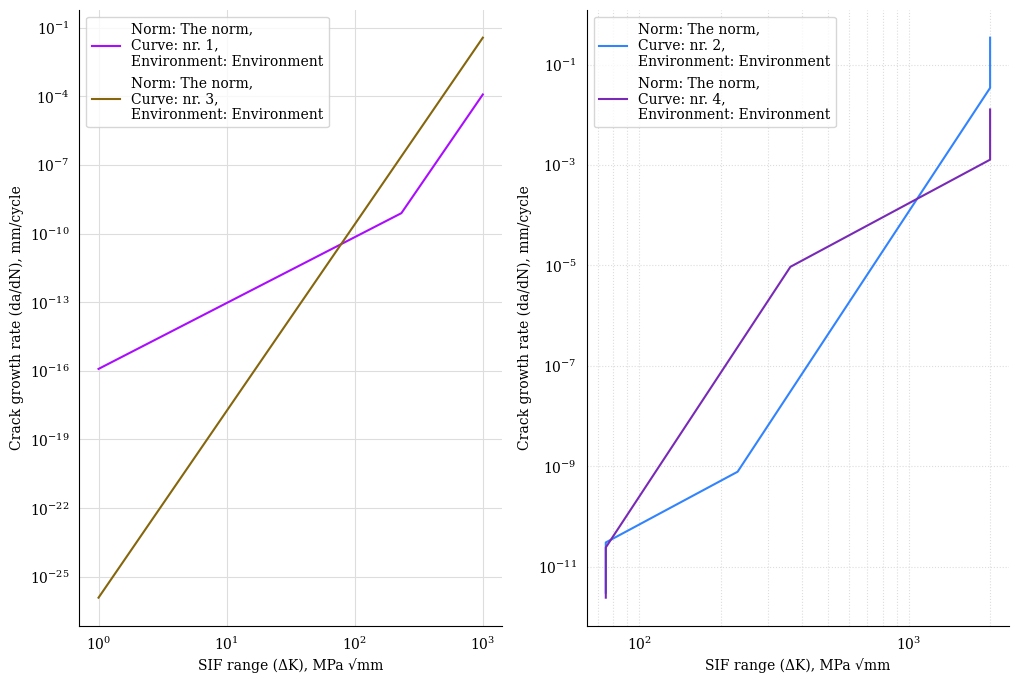

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12, 8))
pc_1.plot(fig=fig, ax=axs[0],)
pc_3.plot(fig=fig, ax=axs[0],)
pc_2.plot(fig=fig, ax=axs[1],)
pc_4.plot(fig=fig, ax=axs[1],)
axs[0].legend()
axs[1].legend()
plt.show()

In [10]:
pc_1.get_knee_sif()

array([231.30554354])

## Crack propagation analysis

### Constant load

In [11]:
max_ = 150
scale_ = [1, 2/3, 4/7, 1/2, 3/7]
_scale = scale_[0]

#### Divided cycles

In [12]:
cd = pf.CycleCount(
    count_cycle=np.ones(10000000),
    stress_range=max_ * np.ones(10000000),
    mean_stress=np.zeros(10000000)
)

#### Clustered cycles

In [13]:
cc = pf.CycleCount(
    count_cycle=np.array([10000000.]),
    stress_range=np.array([max_]),
    mean_stress=np.array([0])
)

### Analytical solution

In [14]:
# Renaming Paris constants
m  = slope = pc_3.slope[0]
C  = intercept = pc_3.intercept[0]
Δσ = scf = max_ * _scale
Y  = 0.8
aⁱ = initial_size = 1.
aᶠ = 80  # 1e1000
π  = np.pi

In [15]:
# analytical = 2 / (2 - slope) / intercept * np.pi ** (-slope / 2) \
#     * scf ** (-slope) * (-(initial_size ** (1 - slope / 2)))
# print("Analytically integrated Nᶠ:", int(analytical))
Nᶠ = 2 / (2 - m) / C * π ** (-m / 2) * (Y * Δσ) ** (-m) \
    * (- aⁱ ** (1 - m / 2)) if m != 2 else \
    1 / (C * π * (Y * Δσ) ** m) * np.log(aᶠ/aⁱ)
print("Analytically integrated Nᶠ:", int(Nᶠ))

Analytically integrated Nᶠ: 2717524


### Numerical solution

#### Geometry

In [16]:
geo = geo = pf.geometry.HollowCylinder(
    initial_depth=1.,
    thickness=80.,
    height=3000.,
    outer_diameter=3000.,
    crack_position="external"
)
geo

HollowCylinder(
  _id=HOL_CYL_01,
  initial_depth=1.0,
  outer_diameter=3000.0,
  thickness=80.0,
  height=3000.0,
  width_to_depth_ratio=2.0,
  crack_position=external,
)

#### Crack growth

In [17]:
cg = pf.crack_growth.get_crack_growth(
    cc * _scale, pc_4, geo
)
print(f"Cycles to failure: {int(cg.final_cycles)}")

Critical SIF reached. Stopping calculation.
Cycles to failure: 3145631


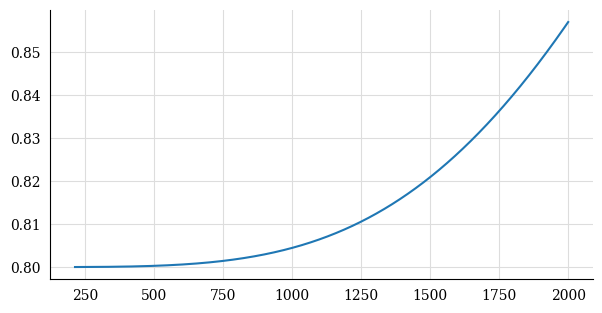

In [18]:
plt.plot(cg.sif, cg.geometry_factor)

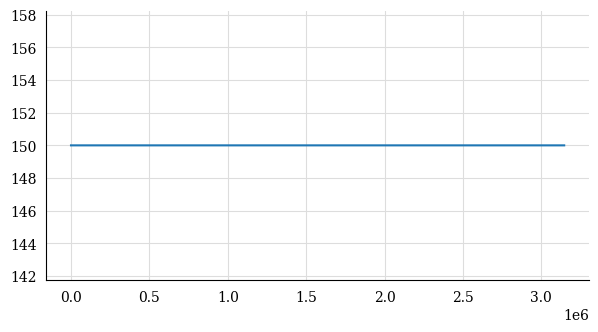

In [19]:
plt.plot(cg.sif / cg.geometry_factor / np.sqrt(np.pi * cg.crack_depth))

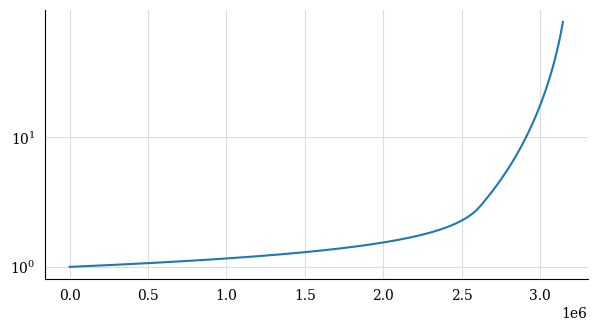

In [20]:
plt.semilogy(np.cumsum(cg.count_cycle)[:len(cg.crack_depth)], cg.crack_depth)

In [21]:
cg.crack_depth[-10:]

array([77.03676516, 77.03804372, 77.03932233, 77.04060097, 77.04187965,
       77.04315837, 77.04443714, 77.04571594, 77.04699477, 77.04827365])

In [22]:
time = pf.testing.get_sampled_time(10, 1000000)

In [23]:
data = pf.testing.get_random_data(t=time, range_=max_ * _scale)

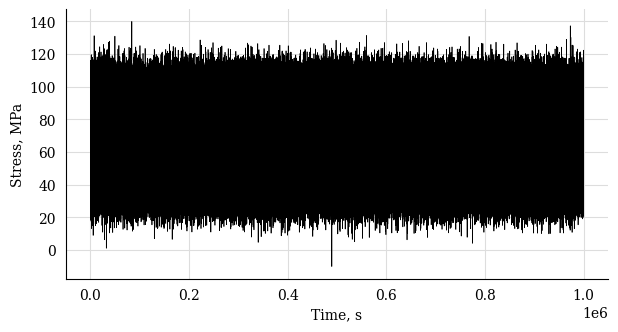

In [24]:
plt.plot(time, data, c="k", lw=0.5)
plt.xlabel("Time, s")
plt.ylabel("Stress, MPa")
plt.show()

In [25]:
cv = pf.CycleCount.from_timeseries(data=data, time=time, range_bin_width=1.25, mean_bin_width=1.25, name="Signal")

In [26]:
cv

,Signal
Cycle counting object,
"largest full stress range, MPa",127.198796
"largest stress range, MPa",150.0
number of full cycles,3333844
number of residuals,26
number of small cycles,0
stress concentration factor,N/A
residuals resolved,False
mean stress-corrected,No


In [27]:
cv * 2

,"Signal, SCF=2.0"
Cycle counting object,
"largest full stress range, MPa",254.397592
"largest stress range, MPa",300.0
number of full cycles,3333844
number of residuals,26
number of small cycles,0
stress concentration factor,2.0
residuals resolved,False
mean stress-corrected,No


(<Figure size 700x350 with 2 Axes>,
 <Axes: xlabel='Min stress, MPa', ylabel='Max stress, MPa'>)

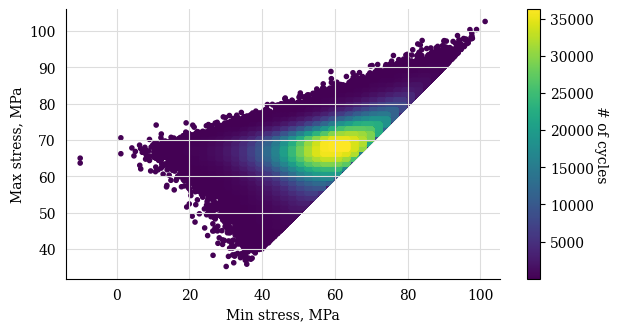

In [ ]:
cv.plot_histogram()

In [29]:
geo = geo = pf.geometry.HollowCylinder(
    initial_depth=15.,
    thickness=80.,
    height=3000.,
    outer_diameter=3000.,
    crack_position="external"
)
geo

HollowCylinder(
  _id=HOL_CYL_01,
  initial_depth=15.0,
  outer_diameter=3000.0,
  thickness=80.0,
  height=3000.0,
  width_to_depth_ratio=2.0,
  crack_position=external,
)

In [30]:
cg = pf.crack_growth.get_crack_growth(
    cv * 2, pc_4, geo, express_mode=True
)
print(f"Cycles to failure: {int(cg.final_cycles)}")

Critical SIF reached. Stopping calculation.
Cycles to failure: 1578626


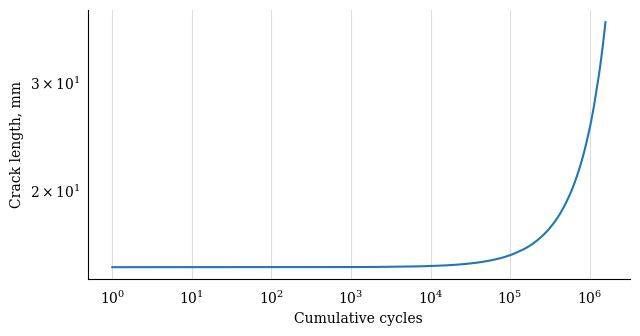

In [31]:
fig, ax = plt.subplots()
ax.loglog(np.cumsum(cg.count_cycle)[:len(cg.crack_depth)], cg.crack_depth)
ax.set_xlabel("Cumulative cycles")
ax.set_ylabel("Crack length, mm")
plt.show()

In [32]:
df = (2 * cv).to_df()

In [33]:
df.cg.calc_growth(cg_curve=pc_3, crack_geometry=geo, express_mode=True)

Crack depth is greater than or equal to the thickness.Stopping calculation.


,count_cycle,mean_stress,stress_range,crack_depth,sif,cumul_cycle,geometry_factor
0,1.0,123.914106,2.823902,15.000000,15.549013,1.0,0.802108
1,0.5,106.965763,67.724293,15.000000,372.904579,1.5,0.802108
2,1.0,141.732570,28.300303,15.000006,155.827611,2.5,0.802108
3,1.0,141.415396,39.426537,15.000006,217.091068,3.5,0.802108
4,1.0,140.540244,14.267073,15.000006,78.557600,4.5,0.802108
...,...,...,...,...,...,...,...
3333865,0.5,136.268353,219.864909,NaN,NaN,NaN,NaN
3333866,0.5,138.602693,215.196230,NaN,NaN,NaN,NaN
3333867,0.5,137.915300,213.821445,NaN,NaN,NaN,NaN
3333868,0.5,153.437432,182.777181,NaN,NaN,NaN,NaN


<Axes: xlabel='sif', ylabel='geometry_factor'>

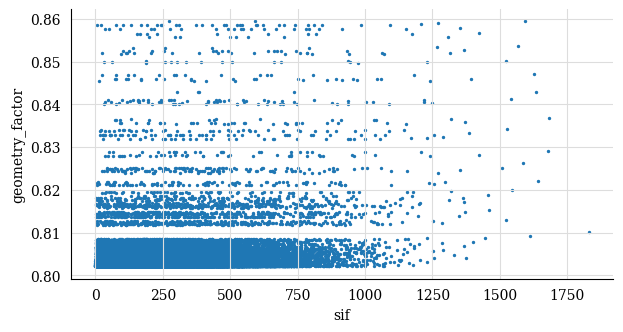

In [34]:
df.plot(kind="scatter", x="sif", y="geometry_factor", s=2)

<Axes: xlabel='cumul_cycle', ylabel='crack_depth'>

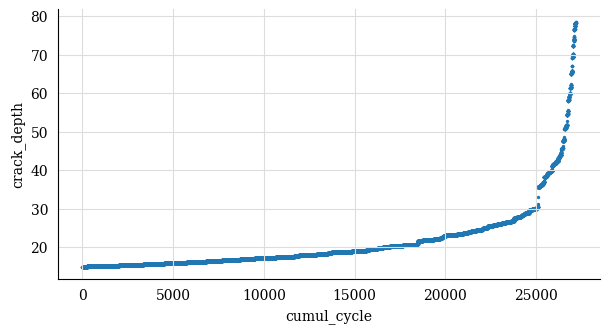

In [35]:
df.plot(kind="scatter", x="cumul_cycle", y="crack_depth", s=2)

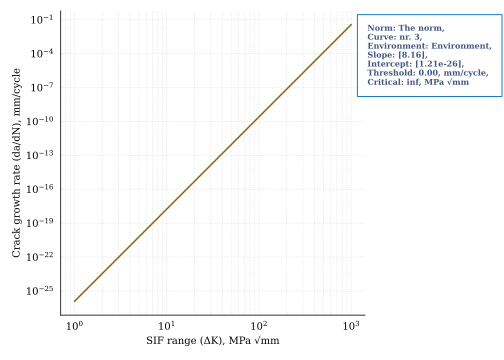

In [36]:
df.cg_curve

In [37]:
df.crack_geometry

HollowCylinder(
  _id=HOL_CYL_01,
  initial_depth=15.0,
  outer_diameter=3000.0,
  thickness=80.0,
  height=3000.0,
  width_to_depth_ratio=2.0,
  crack_position=external,
)

In [38]:
df._metadata

{'name': 'Signal, SCF=2.0',
 'timestamp': datetime.datetime(2024, 9, 2, 17, 17, 30, 891270, tzinfo=datetime.timezone.utc),
 'time_sequence': array([datetime.datetime(2024, 9, 2, 17, 17, 30, 891270, tzinfo=datetime.timezone.utc)],
       dtype=object),
 'residuals_sequence': array([140.82790908,  73.10361613, 209.2234133 ,  66.81840062,
        214.64794021,  59.14184593, 216.03336474,  52.59321121,
        227.17303097,  41.41937624, 232.45792105,  35.40892987,
        239.33308198,  18.09968167, 262.5254813 ,   2.36019524,
        280.        , -20.        , 274.64280166,  21.77564537,
        251.13871951,  26.33589878, 246.200808  ,  31.00457797,
        244.82602301,  62.04884183, 163.77417943]),
 'mean_stress_corrected': 'No',
 'stress_concentration_factor': 2.0,
 'nr_small_cycles': 0,
 'lffd_solved': False,
 'unit': 'MPa'}